In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
import statsmodels.api as sm
from sklearn.decomposition import PCA
import matplotlib.colors
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.colors
from kmodes.kmodes import KModes
from matplotlib.ticker import FuncFormatter
import pandas as pd
import scipy
from scipy.cluster import hierarchy

In [264]:
!mkdir hierarchical_clustering

In [75]:
df = pd.read_pickle('all_data.pkl')

In [3]:
def premium_proportion():
    premiums = ['premium_house', 'premium_life', 'premium_work', 'premium_health', 'premium_motor']
    df['sum_premiums']=0
    for s in premiums:
        df['sum_premiums']+=df.loc[:,s]
    df['balance']=0
    for p in premiums:
        df['balance']+=abs(df.loc[:,p])
    df['balance']=df['sum_premiums']/df['balance']
    for s in premiums:
        df.loc[:,s] /= df['sum_premiums']
    df['engagement'] = df['sum_premiums']/df['month_salary']
    return df

In [4]:
def define_group_variables(df):
    
    """
    Returns :three groups of variables: consume, engagement and categorical
    """
    consume = list(['premium_house', 'premium_health', 'premium_life', 'premium_work', 'premium_motor'])
    categorical = list(['living_area', 'Children'])
    engagement=list(df.columns)
    for v in (consume):
        engagement.remove(v)
    for v in (categorical):
        engagement.remove(v)
    return engagement, consume, categorical

In [5]:
def grouped_data_frames(df):
    """
    Returns data frames grouped by engagement, consume and categorical, respectively
    """
    df_engagement=df.loc[:,engagement]
    df_consume=df.loc[:,consume]
    df_categorical=df.loc[:,categorical]
    return df_engagement, df_consume, df_categorical

In [6]:
def plot_education(original_df, df, array_labels, column_name):
    basic=[]
    high_school=[]
    college=[]
    phd=[]
    degrees=original_df['education'].astype(int).unique()
    m=len(array_labels)
    cmap = plt.get_cmap("viridis", len(degrees))

    for i,j in enumerate(array_labels):
        for k,l in enumerate(degrees):
            if (i)<m:
                mask_labels=df[column_name]==j
                mask_degree=original_df['education'][mask_labels].astype(int)==l
                if l==4:
                    basic.append((mask_labels&mask_degree).sum())
                elif l==12:
                    high_school.append((mask_labels&mask_degree).sum())
                elif l==16:
                    college.append((mask_labels&mask_degree).sum())
                else:
                    phd.append((mask_labels&mask_degree).sum())

    education= pd.DataFrame(basic, columns=['basic'])
    education.insert(education.shape[1], 'high_school' ,high_school)
    education.insert(education.shape[1], 'college' ,college)
    education.insert(education.shape[1], 'phd' ,phd)
    #education.set_index(array_labels)
    total=education['basic']+education['high_school']+education['college']+education['phd']

    total=[i for i in total]
    p=pd.DataFrame()
    p.insert(p.shape[1], 'basic', [i/j*100 for i,j in zip(education['basic'],total)])
    p.insert(p.shape[1], 'high_school', [i/j*100 for i,j in zip(education['high_school'],total)])
    p.insert(p.shape[1], 'college', [i/j*100 for i,j in zip(education['college'],total)])
    p.insert(p.shape[1], 'phd', [i/j*100 for i,j in zip(education['phd'],total)])

    x = [i for i in range(1,(m+1))]
    fig=plt.figure(figsize=(6,4))
    ax=plt.subplot2grid((1,1),(0,0))
    ax.bar(x, p.basic, label='Basic', color=cmap(0))
    ax.bar(x, p.high_school, bottom=p.basic, label='High School', color=cmap(1))
    ax.bar(x, p.college, bottom=[i+j for i,j in zip(p.high_school, p.basic)], label='BSc/MSc', color=cmap(2))
    ax.bar(x, p.phd, bottom=[i+j+k for i,j,k in zip(p.basic, p.high_school, p.college)], label='PhD', color=cmap(3))

    ax.set_xticks([i for i in range(1,(m+1))])
    ax.set_xticklabels(['C%d'%(i) for i in range(1,(m+1))])
    ax.set_ylabel('% in Cluster', fontsize=12)
    ax.legend(loc=0)
    ax.set_title('Education by Cluster')

    plt.savefig('report\education_barplot')

In [7]:
def print_size_clusters(df, array_labels, column_labels):
    sum_count=0
    count_clusters=[]
    print('label|#points')
    for i,j in enumerate(array_labels):
        counts=df[df[column_labels]==j]
        count_clusters.append(len(counts))
        print(j, len(counts))
        sum_count+=len(counts)
    return count_clusters

In [8]:
def plot_clusters(df, array_labels, labels_columns_name, var1, var2, i1, i2, var1_name, var2_name, save_as,
                  x1, y1, x2, y2):
    fig=plt.figure(figsize=(10,4))
    ax=plt.subplot2grid((1,2), (0,0))
    ax2=plt.subplot2grid((1,2), (0,1))
    
    cmap = plt.get_cmap("viridis", len(array_labels[:]))
    for i,j in enumerate(array_labels[:]):
        if ((i<=len(array_labels))):
            ax.scatter(df.loc[:,var1][df[labels_columns_name]==j],
                   df.loc[:,var2][df[labels_columns_name]==j], label='C%d'%(i+1), color=cmap(i),
                      edgecolor='black', linewidth=0.25)
        if ((i==i1)|(i==i2)):
            ax2.scatter(df.loc[:,var1][df[labels_columns_name]==j],
               df.loc[:,var2][df[labels_columns_name]==j], label='C%d'%(i+1), color=cmap(i),
                       edgecolor='black', linewidth=0.25)
        ax.legend(loc=0)
        ax.set_xlabel('%s'%var1_name, fontsize=12)
        ax.set_ylabel('%s'%var2_name, fontsize=12)
        ax.grid(linestyle='dashed', color='gray', alpha=0.35)
        ax2.grid(linestyle='dashed', color='gray', alpha=0.35)
        ax.set_xlim(x1)
        ax2.set_xlim(x2)
        ax.set_ylim(y1)
        ax2.set_ylim(y2)
        
    plt.savefig('%s'%save_as)

In [9]:
def years_customer_plot(df, original_df, name_column, array_labels):
    fig=plt.figure(figsize=(6,4))
    ax=plt.subplot2grid((1,1),(0,0))
    if array_labels!=None:
        x=[(i+1) for i in range(0, len(array_labels))]
        c=['C%d'%(i+1) for i in range(0,len(array_labels))]
        data=[original_df['years_as_customer'][df[name_column]==i] for i in array_labels]
    else:
        x=[(i+1) for i in range(0, len(df[name_column].unique()))]
        c=['C%d'%(i+1) for i in range(0,len(df[name_column].unique()))]
        data=[original_df['years_as_customer'][df[name_column]==i] for i in df[name_column].unique()]
        
    
    ax.boxplot(data)
    ax.set_xticklabels(c)
    ax.set_title('Years as Customer by Cluster', fontsize=12)
    plt.savefig('report\years_customer')

In [76]:
df = premium_proportion()
engagement, consume, categorical= define_group_variables(df)
df_engagement, df_consume, df_categorical = grouped_data_frames(df)
#df_consume=df_consume[df_engagement['claims_rate']<10]
#df_categorical=df_categorical[df_engagement['claims_rate']<10]
#df_engagement=df_engagement[df_engagement['claims_rate']<10]

In [77]:
df_engagement_scaled=pd.DataFrame(StandardScaler().fit_transform(df_engagement), index=df_engagement.index.get_values(), columns=df_engagement.columns)

In [268]:
hierarchy.dendrogram?

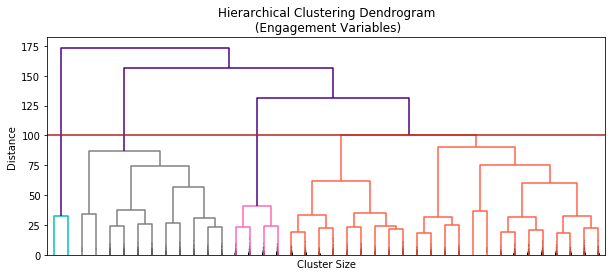

In [12]:
Z = hierarchy.linkage(df_engagement_scaled, method = 'ward')#method='single, complete
fig=plt.figure(figsize=(10,4))
ax=plt.subplot2grid((1,1),(0,0))
hierarchy.set_link_color_palette(['c', 'grey', 'hotpink', 'tomato','darkmangenta','firebrick','midnightblue'])
hierarchy.dendrogram(Z,p= 40, orientation = 'top',leaf_rotation=45.,
           show_contracted=True,show_leaf_counts=True,no_labels=True, truncate_mode='lastp', above_threshold_color='indigo')
ax.set_title('Hierarchical Clustering Dendrogram\n (Engagement Variables)')
ax.set_ylabel('Distance')
ax.set_xlabel('Cluster Size')
plt.axhline(100, color='firebrick')
plt.savefig('hierarchical_clustering\dendrogram')

In [12]:
from sklearn.cluster import AgglomerativeClustering

In [78]:
cluster_engagement=AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
cluster_engagement.fit_predict(df_engagement_scaled)

array([0, 2, 0, ..., 0, 0, 0], dtype=int64)

In [79]:
labels_engagement=pd.DataFrame(cluster_engagement.labels_, index=df_engagement.index.get_values(), columns=['engagement_labels'])
df_engagement=pd.concat([df_engagement_scaled, labels_engagement], axis=1)

In [80]:
size_clusters=print_size_clusters(df_engagement, df_engagement['engagement_labels'].unique(), 'engagement_labels')

label|#points
0 7920
2 1638
1 735
3 3


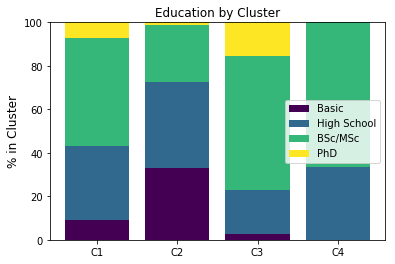

In [32]:
plot_education(df, df_engagement, df_engagement['engagement_labels'].unique(), 'engagement_labels')

### Using all points we have:
* one cluster which is just around average for all variables;
* one cluster of three points with high salary, balance=-0.47, engagement=-0.59 and huge claims and cmv

In [43]:
df_engagement[df_engagement['engagement_labels']==3].describe()

,claims_rate,customer_monetary_value,month_salary,years_as_customer,education,sum_premiums,balance,engagement,engagement_labels
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,51.121508,-49.020372,1.282641,0.004037,0.271790,-0.258209,-0.469115,-0.594255,3.0
std,11.937009,13.079587,0.610418,1.601445,0.534710,0.568797,1.371068,0.076779,0.0
min,42.293696,-61.679191,0.791029,-1.206732,-0.345640,-0.808934,-2.052288,-0.678225,3.0
25%,44.330766,-55.751984,0.941021,-0.903873,0.117432,-0.550855,-0.864908,-0.627564,3.0
50%,46.367837,-49.824778,1.091013,-0.601014,0.580504,-0.292776,0.322472,-0.576903,3.0
75%,55.535414,-42.690962,1.528447,0.609421,0.580504,0.017154,0.322472,-0.552270,3.0
max,64.702992,-35.557146,1.965881,1.819857,0.580504,0.327084,0.322472,-0.527638,3.0


In [81]:
df2=df[df_engagement['engagement_labels']!=3]
df_engagement= df_engagement[df_engagement['engagement_labels']!=3]
df_engagement=df_engagement.drop('engagement_labels', axis=1)

In [82]:
df_engagement_scaled=pd.DataFrame(StandardScaler().fit_transform(df_engagement), index=df_engagement.index.get_values(), columns=df_engagement.columns)

"""Z = hierarchy.linkage(df_engagement_scaled, method = 'ward')#method='single, complete
fig=plt.figure(figsize=(10,4))
ax=plt.subplot2grid((1,1),(0,0))
hierarchy.set_link_color_palette(['c', 'grey', 'hotpink', 'tomato','darkmangenta','firebrick','midnightblue'])
hierarchy.dendrogram(Z,p= 40, orientation = 'top',leaf_rotation=45.,
           show_contracted=True,show_leaf_counts=True,no_labels=True, truncate_mode='lastp', above_threshold_color='indigo')
ax.set_title('Hierarchical Clustering Dendrogram\n (Engagement Variables)')
ax.set_ylabel('Distance')
ax.set_xlabel('Cluster Size')
plt.axhline(100, color='firebrick')
plt.savefig('hierarchical_clustering\dendrogram')"""

"Z = hierarchy.linkage(df_engagement_scaled, method = 'ward')#method='single, complete\nfig=plt.figure(figsize=(10,4))\nax=plt.subplot2grid((1,1),(0,0))\nhierarchy.set_link_color_palette(['c', 'grey', 'hotpink', 'tomato','darkmangenta','firebrick','midnightblue'])\nhierarchy.dendrogram(Z,p= 40, orientation = 'top',leaf_rotation=45.,\n           show_contracted=True,show_leaf_counts=True,no_labels=True, truncate_mode='lastp', above_threshold_color='indigo')\nax.set_title('Hierarchical Clustering Dendrogram\n (Engagement Variables)')\nax.set_ylabel('Distance')\nax.set_xlabel('Cluster Size')\nplt.axhline(100, color='firebrick')\nplt.savefig('hierarchical_clustering\\dendrogram')"

In [83]:
cluster_engagement=AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')

cluster_engagement.fit_predict(df_engagement_scaled)

labels_engagement=pd.DataFrame(cluster_engagement.labels_, index=df_engagement.index.get_values(), columns=['engagement_labels'])

df_engagement=pd.concat([df_engagement_scaled, labels_engagement], axis=1)

size_clusters=print_size_clusters(df_engagement, df_engagement['engagement_labels'].unique(), 'engagement_labels')

label|#points
0 7789
2 1609
3 887
1 8


In [84]:
df3=df2[df_engagement['engagement_labels']!=1]
df_engagement= df_engagement[df_engagement['engagement_labels']!=1]
df_engagement=df_engagement.drop('engagement_labels', axis=1)

In [85]:
df_engagement_scaled=pd.DataFrame(StandardScaler().fit_transform(df_engagement), index=df_engagement.index.get_values(), columns=df_engagement.columns)

"""Z = hierarchy.linkage(df_engagement_scaled, method = 'ward')#method='single, complete
fig=plt.figure(figsize=(10,4))
ax=plt.subplot2grid((1,1),(0,0))
hierarchy.set_link_color_palette(['c', 'grey', 'hotpink', 'tomato','darkmangenta','firebrick','midnightblue'])
hierarchy.dendrogram(Z,p= 40, orientation = 'top',leaf_rotation=45.,
           show_contracted=True,show_leaf_counts=True,no_labels=True, truncate_mode='lastp', above_threshold_color='indigo')
ax.set_title('Hierarchical Clustering Dendrogram\n (Engagement Variables)')
ax.set_ylabel('Distance')
ax.set_xlabel('Cluster Size')
plt.axhline(100, color='firebrick')
plt.savefig('hierarchical_clustering\dendrogram_engagement')"""

"Z = hierarchy.linkage(df_engagement_scaled, method = 'ward')#method='single, complete\nfig=plt.figure(figsize=(10,4))\nax=plt.subplot2grid((1,1),(0,0))\nhierarchy.set_link_color_palette(['c', 'grey', 'hotpink', 'tomato','darkmangenta','firebrick','midnightblue'])\nhierarchy.dendrogram(Z,p= 40, orientation = 'top',leaf_rotation=45.,\n           show_contracted=True,show_leaf_counts=True,no_labels=True, truncate_mode='lastp', above_threshold_color='indigo')\nax.set_title('Hierarchical Clustering Dendrogram\n (Engagement Variables)')\nax.set_ylabel('Distance')\nax.set_xlabel('Cluster Size')\nplt.axhline(100, color='firebrick')\nplt.savefig('hierarchical_clustering\\dendrogram_engagement')"

In [86]:
cluster_engagement=AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')

cluster_engagement.fit_predict(df_engagement_scaled)

labels_engagement=pd.DataFrame(cluster_engagement.labels_, index=df_engagement.index.get_values(), columns=['engagement_labels'])

df_engagement=pd.concat([df_engagement_scaled, labels_engagement], axis=1)

size_clusters=print_size_clusters(df_engagement, df_engagement['engagement_labels'].unique(), 'engagement_labels')

label|#points
3 3547
1 749
0 5340
2 649


In [95]:
df_engagement[df_engagement['engagement_labels']==2].describe()

,claims_rate,customer_monetary_value,month_salary,years_as_customer,education,sum_premiums,balance,engagement,engagement_labels
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.0
mean,0.241296,-0.383624,0.106835,0.023563,0.498072,-0.826928,-3.473770,-0.470608,2.0
std,1.544961,0.907249,0.742896,0.975047,0.775068,0.078912,1.305709,0.227653,0.0
min,-2.087516,-9.749258,-1.983057,-1.811919,-2.196904,-1.044676,-7.053055,-0.777150,2.0
25%,-1.194830,-1.041694,-0.379744,-0.752326,0.580819,-0.878514,-4.269002,-0.606497,2.0
50%,1.007128,-0.846100,0.068742,0.003385,0.580819,-0.825902,-3.366373,-0.523123,2.0
75%,1.313845,0.468728,0.515222,0.760094,0.580819,-0.780707,-2.486229,-0.391475,2.0
max,15.084096,1.113464,2.189772,1.819688,1.738204,-0.419029,0.322396,1.503292,2.0


In [74]:
df_engagement[df_engagement['engagement_labels']==1].head()

,claims_rate,customer_monetary_value,month_salary,years_as_customer,education,sum_premiums,balance,engagement,engagement_labels
2,1.345891,-1.193823,-1.852625,0.760094,-0.345089,0.582108,0.322396,2.595507,1
19,0.091553,0.034074,-1.103141,0.760094,-2.196904,0.523205,0.322396,0.639057,1
109,0.759922,-0.505621,-1.764332,-0.752326,-2.196904,2.150501,0.322396,3.643716,1
150,-0.155653,0.117383,-1.540591,-0.450441,-2.196904,0.010337,0.322396,1.026927,1
183,0.544762,-0.291916,-1.701123,-1.358093,-0.345089,1.297070,0.322396,2.547660,1


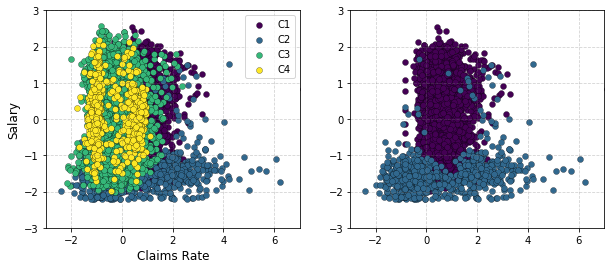

In [73]:
plot_clusters(df_engagement, df_engagement['engagement_labels'].unique(), 'engagement_labels', 'customer_monetary_value', 'month_salary', 
              0,1, 'Claims Rate', 'Salary', 'report\salary_claims_engagement',
              (-3,7), (-3,3), (-3,7), (-3,3))

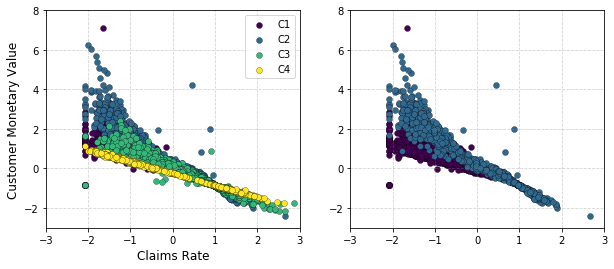

In [88]:
plot_clusters(df_engagement, df_engagement['engagement_labels'].unique(), 'engagement_labels', 'claims_rate', 'customer_monetary_value', 
              0,1, 'Claims Rate', 'Customer Monetary Value', 'report\cmv_claims_engagement',
              (-3,3), (-3,8), (-3,3), (-3,8))

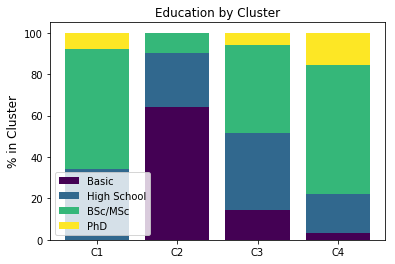

In [67]:
plot_education(df3, df_engagement, df_engagement['engagement_labels'].unique(), 'engagement_labels')

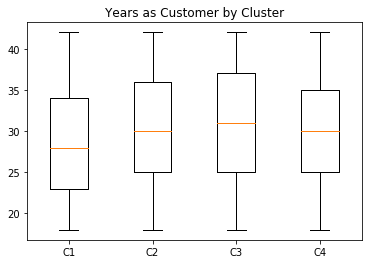

In [97]:
#considering only engagement clusters
years_customer_plot(df_engagement, df3, 'engagement_labels', list(df_engagement['engagement_labels'].unique()))

In [87]:
df_engagement2, df_consume, df_categorical = grouped_data_frames(df3)
df_consume_scaled=pd.DataFrame(StandardScaler().fit_transform(df_consume), index=df_consume.index.get_values(), columns=df_consume.columns)

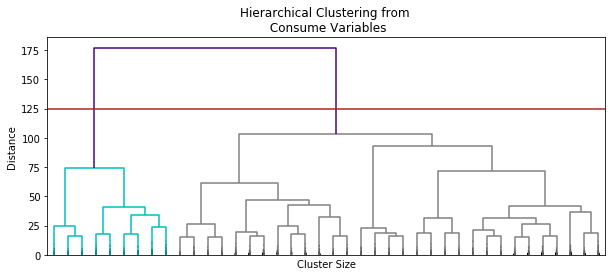

In [28]:
Z = hierarchy.linkage(df_consume_scaled, method = 'ward')#method='single, complete
fig=plt.figure(figsize=(10,4))
ax=plt.subplot2grid((1,1),(0,0))
hierarchy.set_link_color_palette(['c', 'grey', 'hotpink', 'tomato','darkmangenta','firebrick','midnightblue'])
hierarchy.dendrogram(Z,p= 40, orientation = 'top',leaf_rotation=45.,
           show_contracted=True,show_leaf_counts=True,no_labels=True, truncate_mode='lastp', above_threshold_color='indigo')
ax.set_title('Hierarchical Clustering from \n Consume Variables')
ax.set_ylabel('Distance')
ax.set_xlabel('Cluster Size')
plt.axhline(125, color='firebrick')
plt.savefig('hierarchical_clustering\dendrogram_consume')

In [88]:
cluster_consume=AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster_consume.fit_predict(df_consume_scaled)

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [89]:
labels_consume=pd.DataFrame(cluster_consume.labels_, index=df_consume.index.get_values(), columns=['consume_labels'])
df_consume=pd.concat([df_consume_scaled, labels_consume], axis=1)

In [90]:
size_clusters=print_size_clusters(df_consume, df_consume['consume_labels'].unique(), 'consume_labels')

label|#points
1 3839
0 6446


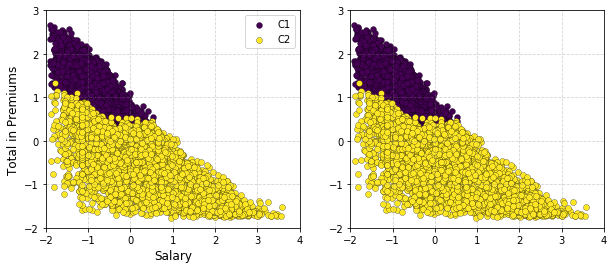

In [71]:
plot_clusters(df_consume, df_consume['consume_labels'].unique(), 'consume_labels', 'premium_house', 'premium_motor', 
              0,1, 'Salary', 'Total in Premiums', 'report\salary_sum_engagement',
              (-2,4), (-2,3), (-2,4), (-2,3))

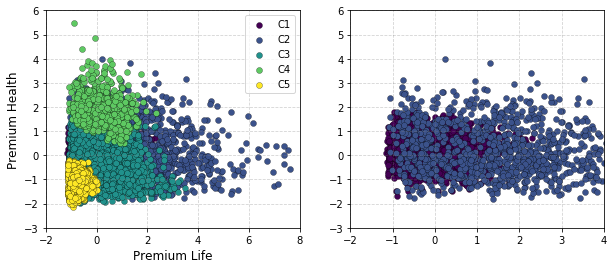

In [51]:
plot_clusters(df_consume, df_consume['consume_labels'].unique(), 'consume_labels', 'premium_life', 'premium_health', 
              0,1, 'Premium Life', 'Premium Health', 'report\life_health_engagement',
              (-2,8), (-3,6), (-2,4), (-3,6))

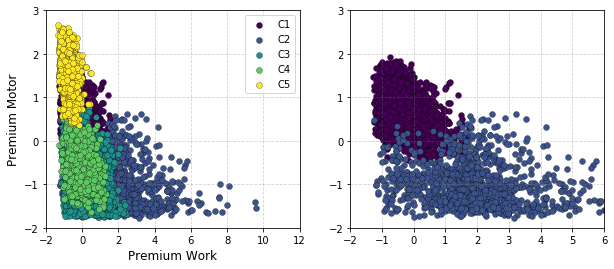

In [52]:
plot_clusters(df_consume, df_consume['consume_labels'].unique(), 'consume_labels', 'premium_work', 'premium_motor', 
              0,1, 'Premium Work', 'Premium Motor', 'report\work_motor_engagement',
              (-2,12), (-2,3), (-2,6), (-2,3))

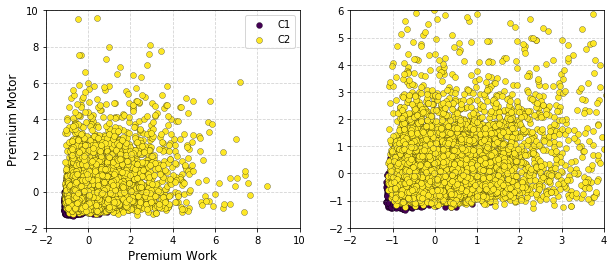

In [72]:
plot_clusters(df_consume, df_consume['consume_labels'].unique(), 'consume_labels', 'premium_life', 'premium_work', 
              0,1, 'Premium Work', 'Premium Motor', 'report\work_motor_engagement',
              (-2,10), (-2,10), (-2,4), (-2,6))

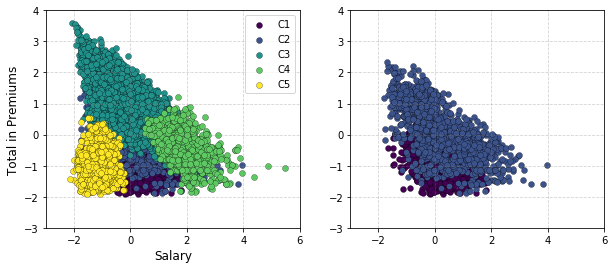

In [55]:
plot_clusters(df_consume, df_consume['consume_labels'].unique(), 'consume_labels', 'premium_health', 'premium_house', 
              0,1, 'Salary', 'Total in Premiums', 'report\salary_sum_engagement',
              (-3,6), (-3,4), (-3,6), (-3,4))

In [64]:
df_consume[df_consume['consume_labels']==0].describe()

,premium_house,premium_health,premium_life,premium_work,premium_motor,consume_labels
count,3842.000000,3842.000000,3842.000000,3842.000000,3842.000000,3842.0
mean,0.925641,-0.153954,0.098210,0.063220,-0.706045,0.0
std,0.779051,0.776758,0.716863,0.655773,0.555166,0.0
min,-0.973910,-2.068045,-1.097948,-1.215787,-1.753831,0.0
25%,0.315439,-0.766379,-0.447813,-0.442442,-1.159755,0.0
50%,0.784182,-0.183042,-0.013800,-0.017634,-0.682283,0.0
75%,1.487369,0.419781,0.503878,0.472573,-0.275164,0.0
max,3.584040,2.084499,3.495215,2.411978,0.762455,0.0


## Combining clusters

In [73]:
def define_label(df, labels1, labels2, labels3):
    """
    Defines final labels as combination from labels1 and labels2
    
    df -> dataframe already with labels
    labels1, labels2 -> names of columns with labels to be combined
    labels3 -> name of the resulting column
    """
    k=0
    count=0
    df[labels3]=''
    for i in list(df[labels1].unique()):
        for j in list(df[labels2].unique()):
            mask1=df.loc[:,labels1]==i
            mask2=df.loc[:,labels2]==j
            df.loc[:,labels3][mask1 & mask2]=k
            k+=1
    return df

In [91]:
df_kmeans=pd.concat([df_engagement, df_consume], axis=1)
df_kmeans=define_label(df_kmeans,'engagement_labels', 'consume_labels', 'labels')
labels=df_kmeans['labels'].unique()
print('NUMBER OF CLUSTERS: %d'%len(labels))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


NUMBER OF CLUSTERS: 8


In [92]:
cluster=AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
cluster.fit_predict(df_kmeans)

array([1, 2, 0, ..., 0, 0, 0], dtype=int64)

In [93]:
size_clusters=print_size_clusters(df_kmeans, df_kmeans['labels'].unique(), 'labels')

label|#points
0 1517
3 743
5 3513
4 1827
1 2030
6 489
7 160
2 6


In [94]:
array_labels=pd.DataFrame(size_clusters, index=df_kmeans['labels'].unique())
for i,j in enumerate(array_labels.iloc[:,-1]):
    if j<100:
        array_labels=array_labels[array_labels.iloc[:,-1]!=j]
array_labels      

,0
0,1517
3,743
5,3513
4,1827
1,2030
6,489
7,160


In [376]:
df_columns=df_kmeans.drop(['engagement_labels', 'consume_labels', 'labels'], axis=1)
df_hierarchical=pd.DataFrame(columns=df_columns.columns, index=array_labels.index.get_values())
for i in array_labels.index.get_values():
    for j in df_columns:
        df_hierarchical.loc[i,j]=df_kmeans[j][df_kmeans['labels']==i].mean()

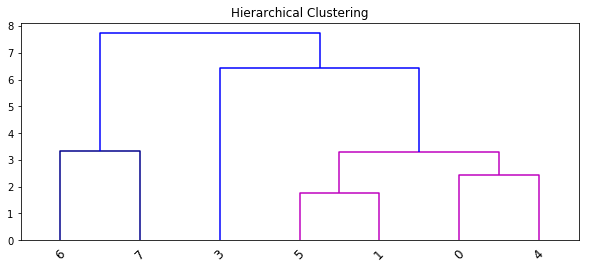

In [377]:
Z = hierarchy.linkage(df_hierarchical, method = 'ward')#method='single, complete
fig=plt.figure(figsize=(10,4))
ax=plt.subplot2grid((1,1),(0,0))
hierarchy.set_link_color_palette(['darkblue', 'm', 'y', 'g','b','r','k'])
hierarchy.dendrogram(Z,p= 40, orientation = 'top',leaf_rotation=45.,
           show_contracted=True,show_leaf_counts=True,labels=df_hierarchical.index.get_values(), truncate_mode='lastp')
ax.set_title('Hierarchical Clustering')
plt.savefig('report\dendrogram')

In [335]:
df_kmeans[df_kmeans['labels']==11]=9

In [378]:
array_labels=pd.DataFrame(size_clusters, index=df_kmeans['labels'].unique())
for i,j in enumerate(array_labels.iloc[:,-1]):
    if j<100:
        array_labels=array_labels[array_labels.iloc[:,-1]!=j]
array_labels      

,0
0,1517
3,743
5,3513
4,1827
1,2030
6,489
7,160


In [367]:
df_kmeans2=pd.concat([df_kmeans2, pd.DataFrame(cluster.labels_, index=df_kmeans2.index.get_values(), columns=['cluster_label'])], axis=1)

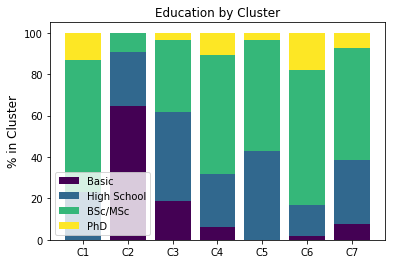

In [403]:
#--
plot_education(df3, df_kmeans, list(array_labels.index.get_values()), 'labels')

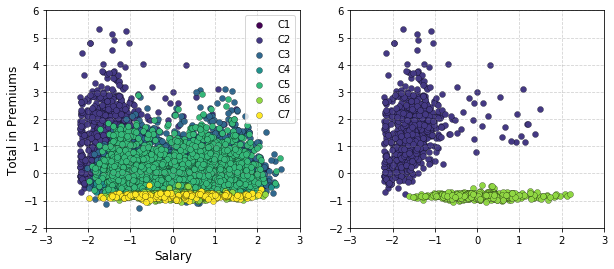

In [432]:
plot_clusters(df_kmeans, list(array_labels.index.get_values()), 'labels', 'month_salary', 'sum_premiums', 
              5,1, 'Salary', 'Total in Premiums', 'report\salary_sum_engagement',
              (-3,3), (-2,6), (-3,3), (-2,6))

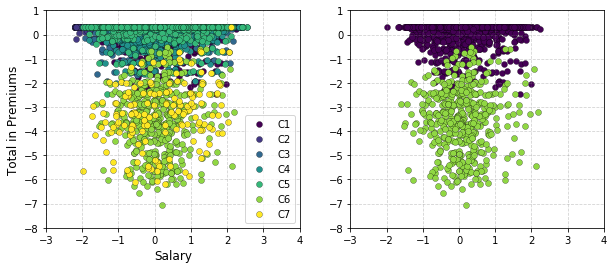

In [434]:
plot_clusters(df_kmeans, list(array_labels.index.get_values()), 'labels', 'month_salary', 'balance', 
              0,5, 'Salary', 'Total in Premiums', 'report\salary_sum_engagement',
              (-3,4), (-8,1), (-3,4), (-8,1))

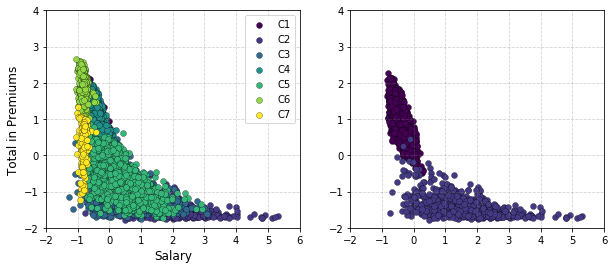

In [435]:
plot_clusters(df_kmeans, list(array_labels.index.get_values()), 'labels', 'sum_premiums', 'premium_motor', 
              0,1, 'Salary', 'Total in Premiums', 'report\salary_sum_engagement',
              (-2,6), (-2,4), (-2,6), (-2,4))

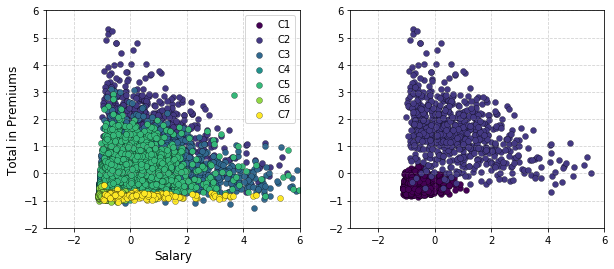

In [421]:
#--
plot_clusters(df_kmeans, list(array_labels.index.get_values()), 'labels', 'premium_life', 'sum_premiums', 
              0,1, 'Salary', 'Total in Premiums', 'report\salary_sum_engagement',
              (-3,6), (-2,6), (-3,6), (-2,6))

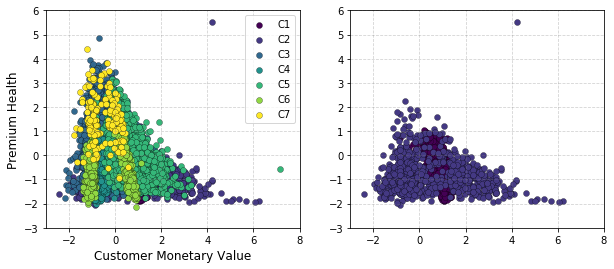

In [420]:
plot_clusters(df_kmeans, list(array_labels.index.get_values()), 'labels', 'customer_monetary_value', 'premium_health', 
              0,1, 'Customer Monetary Value', 'Premium Health', 'report\cmv_health_engagement',
              (-3,8), (-3,6), (-3,8), (-3,6))

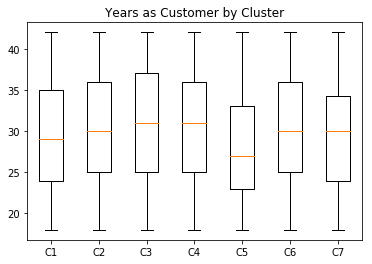

In [397]:
#considering only engagement clusters
years_customer_plot(df_kmeans, df3, 'labels', list(array_labels.index.get_values()))

In [95]:
list(array_labels.index.get_values())

[0, 3, 5, 4, 1, 6, 7]

In [157]:
df3[df_kmeans['labels']==6].describe()

,Children,claims_rate,customer_monetary_value,month_salary,premium_health,premium_house,premium_life,premium_motor,premium_work,years_as_customer,education,living_area,sum_premiums,balance,engagement
count,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000
mean,0.903885,0.718004,127.360511,2579.885762,0.156736,-0.076170,0.013579,0.892412,0.013443,30.240914,16.106339,2.611452,543.629982,0.862476,0.225178
std,0.295050,0.500740,273.221260,629.371814,0.076774,0.036526,0.016904,0.097424,0.021798,6.448698,3.041540,1.286895,20.449850,0.046338,0.065399
min,0.000000,0.000290,-2642.933593,919.955473,-0.003860,-0.153520,-0.013416,0.596477,-0.024581,18.003780,4.000000,1.000000,487.248854,0.737353,0.117479
25%,1.000000,0.230192,-88.894111,2179.805716,0.093562,-0.094652,0.001830,0.821240,-0.003472,25.005281,16.000000,1.000000,530.217425,0.832119,0.184527
50%,1.000000,1.039328,-45.280775,2563.882318,0.143411,-0.074377,0.011360,0.896384,0.011029,29.998805,16.000000,3.000000,543.744111,0.866196,0.211554
75%,1.000000,1.119943,386.597621,2914.389243,0.215542,-0.055066,0.021169,0.963303,0.024330,35.996318,16.000000,4.000000,555.275890,0.898901,0.251709
max,1.000000,5.600047,547.222345,4655.075746,0.364894,0.130580,0.104925,1.103320,0.114532,42.000435,21.000000,4.000000,647.589160,0.969791,0.594871


In [119]:
no_children=[]
with_children=[]
k=8
for i,j in enumerate(array_labels.index.get_values()):
    if (i+1)<k:
        mask_labels=df_kmeans['labels']==j
        mask_children=df['Children']==1.0
        no_children.append((mask_labels&~mask_children).sum())
        with_children.append((mask_labels&mask_children).sum())
no_children=pd.DataFrame(no_children, columns=['nc'])
with_children=pd.DataFrame(with_children, columns=['wc'])
total=[i+j for i,j in zip(with_children['wc'], no_children['nc'])]

In [120]:
no_children1 = [(i/j*100 if j>0 else 0) for i,j in zip(no_children['nc'], total)]
with_children1=[(i/j*100 if j>0 else 0) for i,j in zip(with_children['wc'], total)]

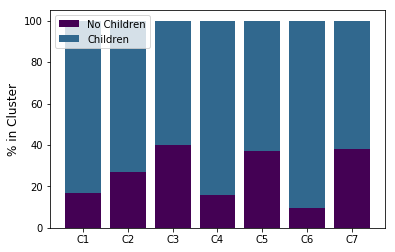

In [121]:
cmap = plt.get_cmap("viridis", len(array_labels))
x = [i for i in range(1,k)]
fig=plt.figure(figsize=(6,4))
ax=plt.subplot2grid((1,1),(0,0))
ax.bar(x, no_children1, label='No Children', color=cmap(0))
ax.bar(x, with_children1, bottom=no_children1, label='Children', color=cmap(2))
xticks=[i for i in range(1,k)]
ax.set_xticks(xticks)
ax.set_xticklabels(['C%d'%i for i in range(1,k)])
ax.set_ylabel('% in Cluster', fontsize=12)
ax.legend(loc=2)
plt.savefig('report\children_kmeans')